![Demosaicking](https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/0129bbd70539e5c601b76b03e4d3883f67c39e72/Sesiones/Sesion2/Images/poster_sesion2.png)

# 🎨 **Hands-on Sesión 2.1: Image Demosaicking** 🏞️

## 📌 Introducción

**Demosaicking** (o de-mosaicing) es un algoritmo utilizado en el procesamiento de imágenes digitales para reconstruir imágenes a todo color a partir de datos incompletos obtenidos por un sensor de imagen con una matriz de filtros de color (CFA), como el filtro Bayer.

📷 **Cámaras digitales modernas** usan sensores con CFA, lo que hace que el demosaicking sea crucial para obtener imágenes visibles y de alta calidad. Las imágenes RAW permiten que este proceso se haga vía software en vez del firmware de la cámara.


## 📸 **Formatos de imágenes RAW más comunes**

| Extensión | Descripción                           | Extensión | Descripción                                |
|-----------|--------------------------------------|-----------|--------------------------------------------|
| .DNG      | Apple ProRAW Image                  | .ARW      | Sony Alpha Raw Digital Camera Image       |
| .CR2      | Canon Raw 2 Image File              | .SR2      | Sony RAW Image                            |
| .CR3      | Canon Raw 3 Image File              | .SRF      | Sony RAW Image                            |
| .CRW      | Canon Raw CIFF Image File           | .NEF      | Nikon Electronic Format RAW Image         |
| .CS1      | CaptureShop 1-shot Raw Image        | .NRW      | Nikon Raw Image                           |


## 🔧 Librerías necesarias

In [1]:
%%capture
# @title librerías

!pip install -q rawpy
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
import rawpy
from scipy.ndimage import convolve

## 📥 Descargando imágenes RAW

Los raw disponibles son `raw.CR2`, `raw_Canon.CR2`, `raw_Canon2.CR2`, `raw_GOPRO1.dng`, `raw_GOPRO2.dng`, `raw_Nikon.NEF`.

In [2]:
# @title Seleeciona el archivo raw
raw_file = "raw.CR2"  # @param {type:"string"}

In [3]:
# @title descargar raw
raw_files = {
    "raw.CR2": "https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/refs/heads/2024/Sesiones/Sesion2/Imagenes/raw.CR2",
    "raw_Canon.CR2": "https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/refs/heads/2024/Sesiones/Sesion2/Imagenes/raw_Canon.CR2",
    "raw_Canon2.CR2": "https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/refs/heads/2024/Sesiones/Sesion2/Imagenes/raw_Canon2.CR2",
    "raw_GOPRO1.dng": "https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/refs/heads/2024/Sesiones/Sesion2/Imagenes/raw_GOPRO1.dng",
    "raw_GOPRO2.dng": "https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/refs/heads/2024/Sesiones/Sesion2/Imagenes/raw_GOPRO2.dng",
    "raw_Nikon.NEF": "https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/refs/heads/2024/Sesiones/Sesion2/Imagenes/raw_Nikon.NEF"
}

url = raw_files[raw_file]
!wget -O $raw_file $url

--2025-03-10 22:25:14--  https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/refs/heads/2024/Sesiones/Sesion2/Imagenes/raw.CR2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10179236 (9.7M) [application/octet-stream]
Saving to: ‘raw.CR2’

raw.CR2             100%[===================>]   9.71M  --.-KB/s    in 0.1s    

2025-03-10 22:25:15 (71.3 MB/s) - ‘raw.CR2’ saved [10179236/10179236]



## 🖼️ **1. Probemos con una imagen**<a name="tema2"></a> 📷

Vamos a leer y visualizar una imagen RAW.

📖 Leyendo imagen .RAW ...
📏 Tamaño de la imagen: (2622, 3948)


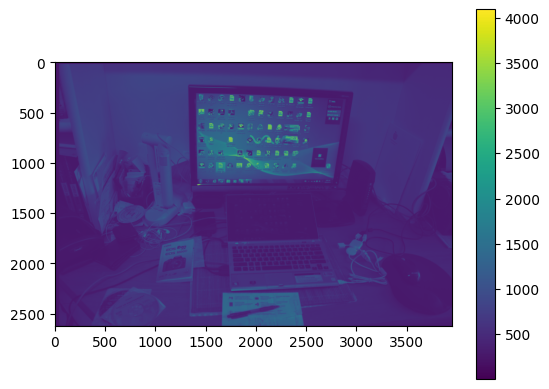

In [4]:
with rawpy.imread(raw_file) as raw:
    print('📖 Leyendo imagen .RAW ...')
    image = raw.raw_image.copy()

print(f'📏 Tamaño de la imagen: {image.shape}')
plt.imshow(image)
plt.colorbar()
plt.show()

🛠️ **Ejercicio:** Selecciona y visualiza diferentes zonas de la imagen.

🔎 Hagamos Zoom para ver el patrón Bayer.

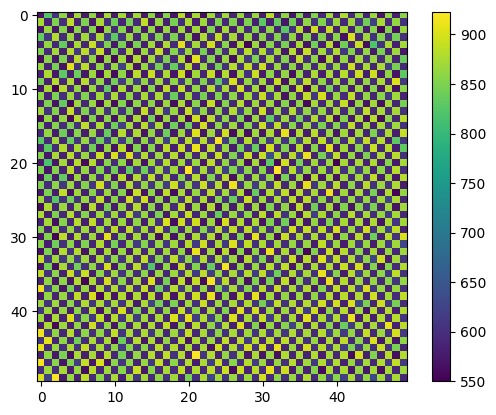

In [5]:
plt.imshow(image[250:300, 200:250]) # 🛠️ Cambia los valores para explorar otras regiones
plt.colorbar()
plt.show()

## 🌈 **2. Hagamos demosaicking** <a name="tema3"></a> 🎨

**Objetivo:** Separar la imagen en sus canales RGB.

La función `get_cfa_channel` debe devolver 0 en rojo, 1 en verde, y 2 en blue.
La función `get_cfa_mask` debe devolver una matrix de tamaño de la imagen original, donde cada valor corresponde a 0, 1 o 2

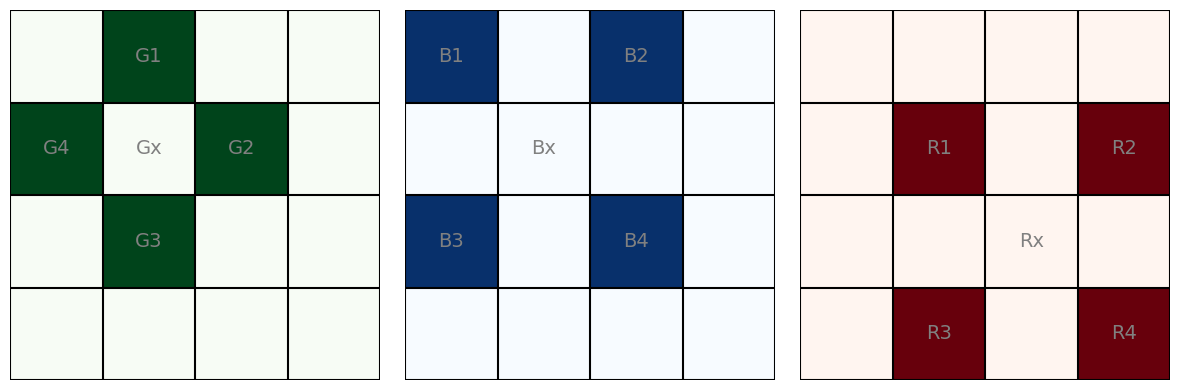

In [6]:
# @title interpolación bilineal
import matplotlib.pyplot as plt
import numpy as np

# Crear matrices 4x4
green_matrix = np.zeros((4, 4))
blue_matrix = np.zeros((4, 4))
red_matrix = np.zeros((4, 4))

# Asignar unos donde corresponde
green_positions = [(0, 1), (1, 0), (1, 2), (2, 1)]
blue_positions = [(0, 0), (0, 2), (2, 0), (2, 2)]
red_positions = [(1, 1), (1, 3), (3, 1), (3, 3)]

for i, j in green_positions:
    green_matrix[i, j] = 1

for i, j in blue_positions:
    blue_matrix[i, j] = 1

for i, j in red_positions:
    red_matrix[i, j] = 1

# Etiquetas en cada celda
green_labels = {(0, 1): 'G1', (1, 0): 'G4', (1, 2): 'G2', (2, 1): 'G3', (1, 1): 'Gx'}
blue_labels = {(0, 0): 'B1', (0, 2): 'B2', (2, 0): 'B3', (2, 2): 'B4', (1, 1): 'Bx'}
red_labels = {(1, 1): 'R1', (1, 3): 'R2', (3, 1): 'R3', (3, 3): 'R4', (2, 2): 'Rx'}

# Función para graficar la matriz con etiquetas y cuadrícula
def plot_matrix(ax, matrix, cmap, labels):
    ax.imshow(matrix, cmap=cmap, vmin=0, vmax=1)

    # Agregar líneas de la cuadrícula
    for i in range(5):
        ax.plot([-0.5, 3.5], [i - 0.5, i - 0.5], color='black', linewidth=1.5)  # Horizontales
        ax.plot([i - 0.5, i - 0.5], [-0.5, 3.5], color='black', linewidth=1.5)  # Verticales

    # Agregar etiquetas
    for (i, j), text in labels.items():
        ax.text(j, i, text, ha='center', va='center', fontsize=14, color='gray')

    # Quitar ejes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

# Crear la figura
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Graficar cada matriz con sus etiquetas y cuadrícula
plot_matrix(axes[0], green_matrix, 'Greens', green_labels)
plot_matrix(axes[1], blue_matrix, 'Blues', blue_labels)
plot_matrix(axes[2], red_matrix, 'Reds', red_labels)

plt.tight_layout()
plt.show()

2 1 1 0


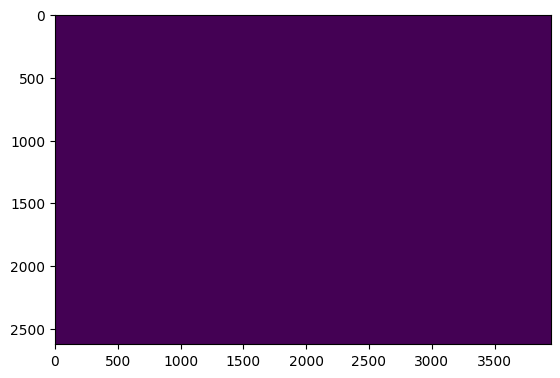

In [16]:
RED, GREEN, BLUE = 0, 1, 2


def get_cfa_channel(i, j):
    if i%2==1 and j%2==1:
      return RED
    if i%2==0 and j%2==0:
      return BLUE
    else:
      return GREEN


def get_cfa_mask(shape):
  def get_cfa_mask(shape):
    a=np.zeros(shape)
    for i in range(shape[0]):
      for j in range(shape[1]):
        a[i,j]=get_cfa_channel(i,j)
    return a



cfa_mask = get_cfa_mask(image.shape)
print(get_cfa_channel(0, 0), get_cfa_channel(0, 1), get_cfa_channel(1, 0), get_cfa_channel(1, 1))
r_mask, g_mask, b_mask = (cfa_mask == RED), (cfa_mask == GREEN), (cfa_mask == BLUE)

r, g, b = image * r_mask, image * g_mask, image * b_mask

plt.imshow(r + g + b)
plt.show()

✅ **Siguiente paso:** Completa los huecos en la imagen interpolando los valores faltantes.
Esta vez, vamos a utilizar convoluciones y sus kernel de convolución.

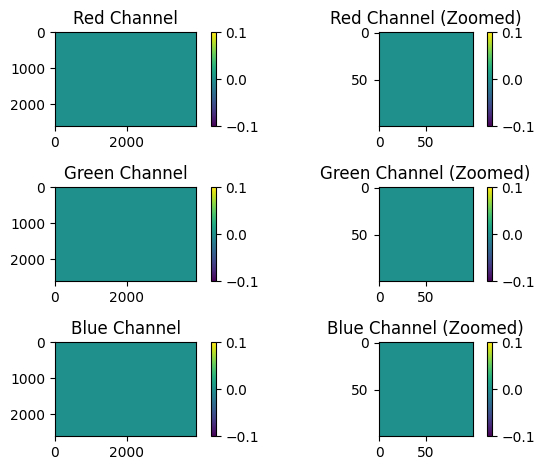

In [12]:
# 🏆 Escribe aquí el código para completar los valores faltantes:

#Filtro lineal para el canal verde
G_KERNEL = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

#Filtro lineal para los canales azul y rojo (Note la diferencia)
RB_KERNEL = np.array([[1, 0, 1], [0, 0, 0], [1, 1, 1]])



r = convolve(r, RB_KERNEL, mode='nearest')
b = convolve(b, RB_KERNEL, mode='nearest')
g = convolve(g, G_KERNEL, mode='nearest')

channels = [r, g, b]
titles = ['Red Channel', 'Green Channel', 'Blue Channel']

for i, channel in enumerate(channels):
    plt.subplot(3, 2, 2*i + 1)
    plt.imshow(channel)
    plt.title(titles[i])
    plt.colorbar()

    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(channel[310:410, 1405:1505])
    plt.title(f'{titles[i]} (Zoomed)')
    plt.colorbar()

plt.tight_layout()
plt.show()


---
## 🎯 **3. Correcciones de color** <a name="tema4"></a> 🌈

<ipython-input-15-b7976c295954>:11: RuntimeWarning: invalid value encountered in divide
  rgb = (rgb - min_val) / (max_val - min_val)  # Normalización Min-Max por canal


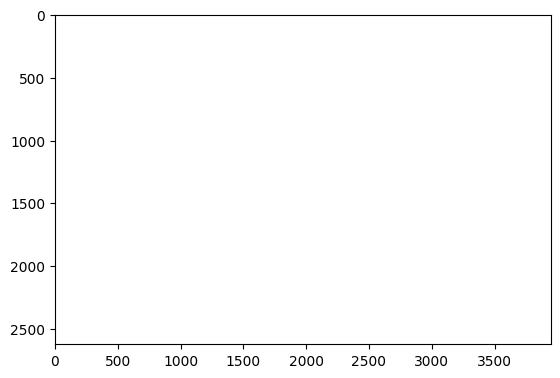

In [15]:
# Definimos el valor de gamma para la corrección gamma
gamma = 2.8 # 🛠️ Puedes cambiar este valor para ver cómo afecta a la imagen

# Apilamos los canales rojo, verde y azul para formar una imagen RGB
rgb = np.stack([r,g,b], axis=-1)  # 🛠️ Completar la función para apilar los canales

# # Normalización independiente por canal
min_val = np.min(rgb, axis=(0, 1))  # Mínimo por canal
max_val = np.max(rgb, axis=(0, 1))  # Máximo por canal

rgb = (rgb - min_val) / (max_val - min_val)  # Normalización Min-Max por canal

# Aplicamos la corrección gamma a la imagen RGB
rgb = (np.power(rgb, 1.0 / gamma) )

# Mostramos la imagen resultante
plt.imshow((rgb))
plt.show()

🔍 **¡Ahora puedes comparar con métodos avanzados de RAWPY!** 🚀

Reading image raw data...


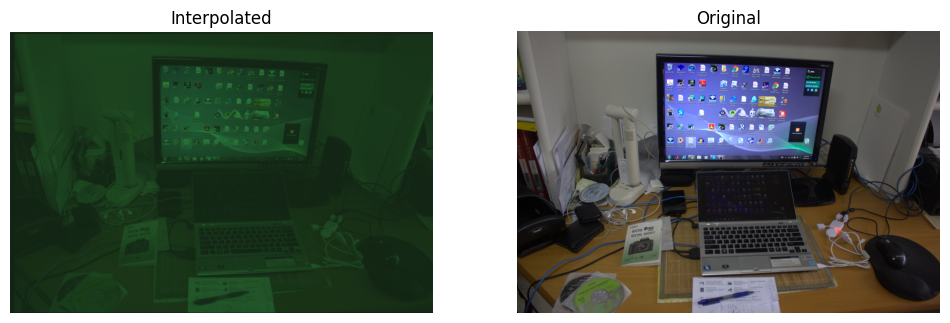

In [ ]:
# Comparando contra la imagen original
with rawpy.imread(raw_file) as raw:
    print('Reading image raw data...')
    rgb2 = raw.postprocess(use_camera_wb=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(rgb)
axes[0].set_title('Interpolated')
axes[0].axis('off')
axes[1].imshow(rgb2)
axes[1].set_title('Original')
axes[1].axis('off')
plt.show()